# Toy examples

Here I want to show how propensity score works using toy examples, so that this theory can be further developed on large models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from utils import compute_metrics
np.random.seed(48)

## 1. Distributions

Let's consider that we have test set with normal distribution (0,1). To illustrate the example, suppose we know the parameters of the changed test data over time and now they equal to (1.5, 1)

In [3]:
test_old = np.random.normal(0, 1, size = 10000)
test_uptodate = np.random.normal(1.5, 1, size = 10000)

We can see for these histograms.

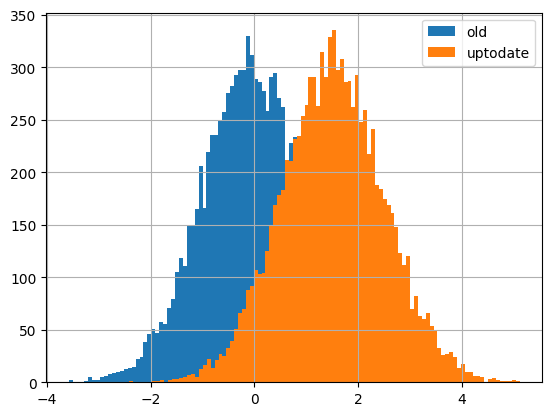

In [34]:
plt.hist(test_old, bins=100, label='old');
plt.hist(test_uptodate, bins=100, label='uptodate');
plt.legend();
plt.grid()

What we want now? Get weights in a manner of propensity scores, to reweight our ```test_old``` data to be now closer to the uptodate one.

Let's try to do this using logistic regression. Сonsider two random subsamples from both test sets (old, up-to-date). Let the old set be labelled with ```1``` and the new one with ```0```. Then, we can estimate the propensity score as the probability of not getting labelled 1.

$$
propensity\_score(x) = 1 - \frac{1}{1+e^{-x}}
$$

The power of the subsamples is chosen to be 10% of the total number of each.

In [7]:
subsample = np.random.choice(test_old, size=1000).tolist() + np.random.choice(test_uptodate, size=1000).tolist()
y = [1] * 1000 + [0] * 1000

In [8]:
X_train, _, y_train, _ = train_test_split(subsample, y, test_size=0.0001, random_state=None, shuffle=True)

In [10]:
clf = LogisticRegression().fit(np.array(X_train).reshape(-1, 1), y_train)

After obtaining the trained model, obtain the weights. We need the probability of belonging to class ```0```, and we also need to normalise all weights.

In [23]:
weights = [clf.predict_proba(item.reshape(1, -1))[0][0] for item in test_old]
weights /= np.sum(weights)

Let's sample two sets from the ```test_old``` with new weights. In the first one we assume the possibility of sample repetition, which will reflect the influence of the weight of each sample on the overall distribution. In the second one, we forbid sample repetition, but make the sample size smaller.

In [29]:
sample_1 = np.random.choice(test_old, size=10000, p=weights, replace=True)
sample_2 = np.random.choice(test_old, size=5000, p=weights, replace=False)

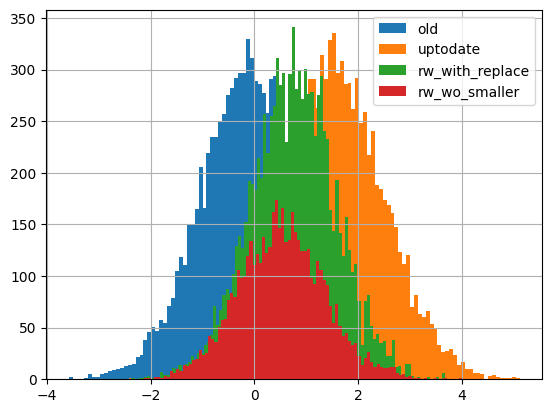

In [35]:
plt.hist(test_old, bins=100, label='old');
plt.hist(test_uptodate, bins=100, label='uptodate');
plt.hist(sample, bins=100, label='rw_with_replace');
plt.hist(sample1, bins=100, label='rw_wo_smaller');
plt.legend();
plt.grid()

We can notice the movement of our weighted points towards the correct uptodate distribution.

## 2. Auto Insurance in Sweden

In this subsection, I consider an example of applying the technique with object weighting on a [public dataset](https://www.kaggle.com/datasets/redwankarimsony/auto-insurance-in-sweden?resource=download) with price information in Swedish kronor based on a single feature. This example aims to illustrate the usefulness of applying object weighting when encountering data target distribution shifts in real-world problems.

The data originally contains 63 samples, here I applied some of the augmentation to make the example clearer. The structure of data distribution and correct labels has not changed. More about that in Appendix.

In [2]:
data = pd.read_csv('./swedish_insurance_augmented.csv')

In [3]:
data

,X,Y
0,108.000000,392.500000
1,19.000000,46.200000
2,13.000000,15.700000
3,124.000000,422.200000
4,40.000000,119.400000
...,...,...
498,87.396910,302.251503
499,-213.435581,-1097.322140
500,-15.050528,-92.783053
501,20.030793,152.546669


### Pipeline

So, about data: we have samples with one feature and correct label to each of them. Firstly, I want to show the performance of simple LinearRegression approach on test part which distribution has same structure as train.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                        data["X"], 
                                        data["Y"], 
                                        test_size=0.31, 
                                        random_state=None, 
                                        shuffle=True
                                    )

print(f"Length of train part: {len(X_train)}\nLength of original test part: {len(X_test)}")

Length of train part: 347
Length of original test part: 156


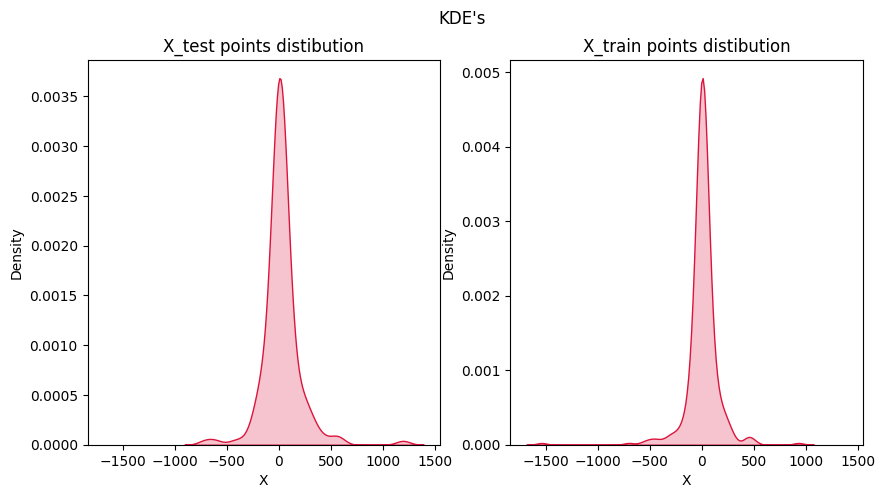

In [5]:
figure, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
figure.suptitle("KDE's")
axes[0].set_title('X_test points distibution')
axes[1].set_title('X_train points distibution')

sns.kdeplot(data=X_test,
            color='crimson', label='test', fill=True, ax=axes[0])
sns.kdeplot(data=X_train,
            color='crimson', label='train', fill=True, ax=axes[1]);

Below, I obtain the linear regression model. Let's evaluate its quality with correct labels and predicted using the coefficient of determination R2 - the proportion of the variation in the dependent variable that is predictable from the independent variable.

In [6]:
regressor = LinearRegression().fit(np.array(X_train.values).reshape(-1, 1), y_train)

print(f"R2 score on original test data: {r2_score(y_test, regressor.predict(np.array(X_test.values).reshape(-1,1)))}")
print(f"MSE score on original test data: {mean_squared_error(y_test, regressor.predict(np.array(X_test.values).reshape(-1,1)))}")

R2 score on original test data: 0.9348021136126776
MSE score on original test data: 34660.931894278874


Now consider another test data part that was obtained from the original test data by applying several distortions and has a target distibution shift. More details can be found in the Appendix section. 

In [7]:
tsd_test_data = pd.read_csv('./tds_test.csv')

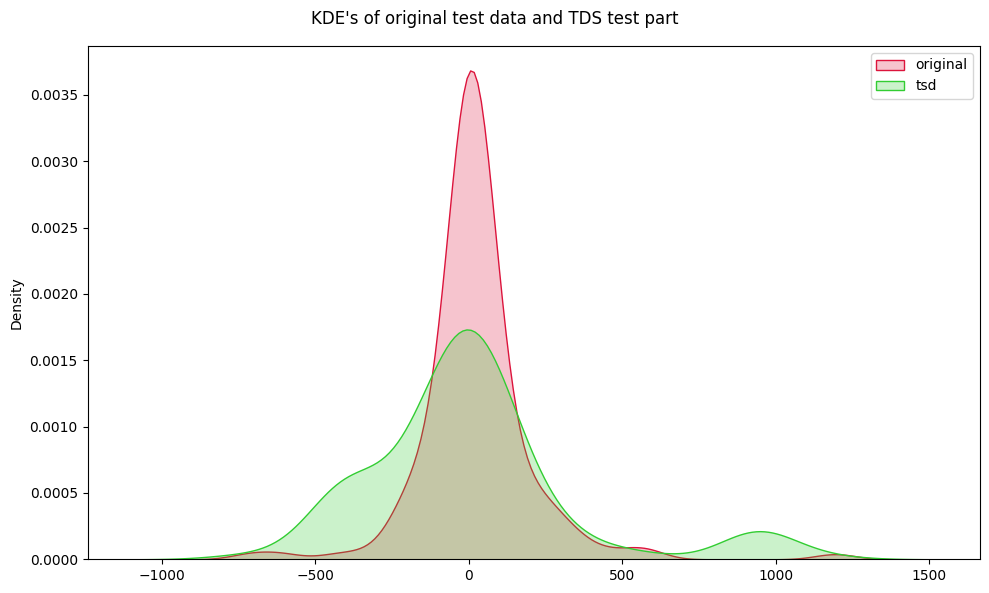

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("KDE's of original test data and TDS test part")
sns.kdeplot(data=X_test.values,
            color='crimson', label='original', fill=True, ax=ax)
sns.kdeplot(data=tsd_test_data["X"].values,
            color='limegreen', label='tsd', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

Try to estimate the qualities of the linear regression model on data with a different distribution without any additional adjustments.

In [9]:
print(f"R2 score on TDS data w/o weights: {r2_score(tsd_test_data['Y'], regressor.predict(np.array(tsd_test_data['X']).reshape(-1,1)))}")
print(f"MSE score on TDS data w/o weights: {mean_squared_error(tsd_test_data['Y'], regressor.predict(np.array(tsd_test_data['X']).reshape(-1,1)))}")

R2 score on TDS data w/o weights: 0.8254543654538737
MSE score on TDS data w/o weights: 348614.98574268847


Now our task is to obtain propensity score weights to reweight the model predictions to provide a more correct estimate of the quality of the trained model. For this purpose, let us sample n examples from the original test sample and from the corrupted one. We train a simple RandomForest-based classifier, which will show the probability of belonging to class 0 or 1 for each sample. 
In our case:
- 0 - belonging to the corrupted test sample;
- 1 - belonging to the original test sample.

In [10]:
sample_from_old = np.random.choice(y_test, size=100, replace=False)
sample_from_new = np.random.choice(tsd_test_data["Y"], size=100, replace=False) 

X_logreg = np.concatenate((sample_from_old, sample_from_new), axis=0)
t = [1] * len(sample_from_old) + [0] * len(sample_from_new)

X_train_lg, _, y_train_lg, _ = train_test_split(X_logreg, t, test_size=0.0001, random_state=None, shuffle=True)
rf = RandomForestClassifier().fit(X_train_lg.reshape(-1, 1), y_train_lg)

To get the weights, we will use the predict_proba method of the trained classifier and apply it to each sample from the original test dataset. Thus, we will get a weight - the probability of a given sample to belong to the corrupted data distribution, which will help us to simulate the situation when we want to test the model after some time and the distribution in the data has changed.

In [11]:
weights = [rf.predict_proba(item.reshape(1, -1))[0][0] for item in X_test.values]

In [12]:
weights[10:20]

[0.67, 0.0, 0.24, 0.66, 0.01, 0.92, 0.36, 0.73, 0.28, 0.37]

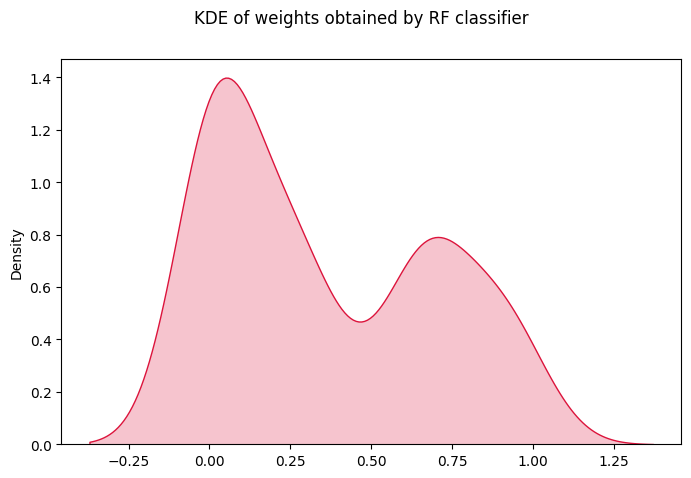

In [13]:
figure, axes = plt.subplots(1, 1, sharex=True, figsize=(8,5))
figure.suptitle("KDE of weights obtained by RF classifier")

sns.kdeplot(data=weights,
            color='crimson', label='test', fill=True, ax=axes);

Also, we can verify that "true weights" applied on the KDE of the original distribution recovers the KDE of TSD.



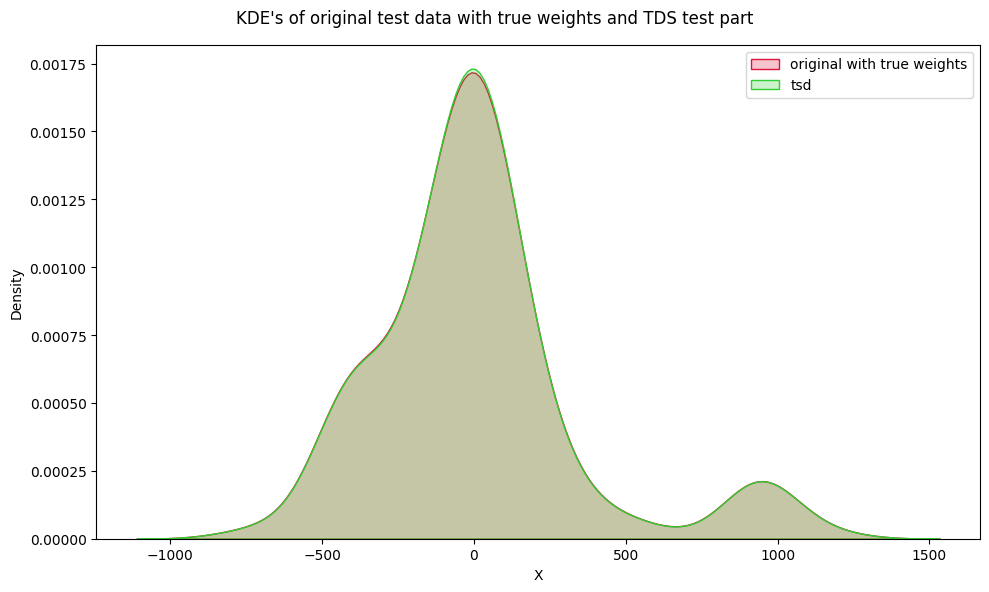

In [14]:
true_weights = tsd_test_data["X"] / X_test.values

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("KDE's of original test data with true weights and TDS test part")
sns.kdeplot(data=true_weights * X_test.values,
            color='crimson', label='original with true weights', fill=True, ax=ax)
sns.kdeplot(data=tsd_test_data["X"].values,
            color='limegreen', label='tsd', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

However, if we look at the given true weights, we can see that they are outside the range (0,1), and therefore it seems pointless to compare them with the predicted ones in the current setting. Let's normalise the weights to bring them to the range (0,1):

In [15]:
true_weights.values[:10]

array([ 0.82429671,  1.61779021,  2.68981033,  2.44211161, -0.55386304,
        1.87354075, 13.60782757,  1.69861092, 14.8269178 ,  2.66666667])

In [16]:
true_weights = true_weights.replace([np.inf], 1)
true_weights_norm = (np.array(true_weights) - np.min(true_weights)) / (np.max(true_weights) - np.min(true_weights))

Let's look at how our predicted RF weights change KDE of original test data:

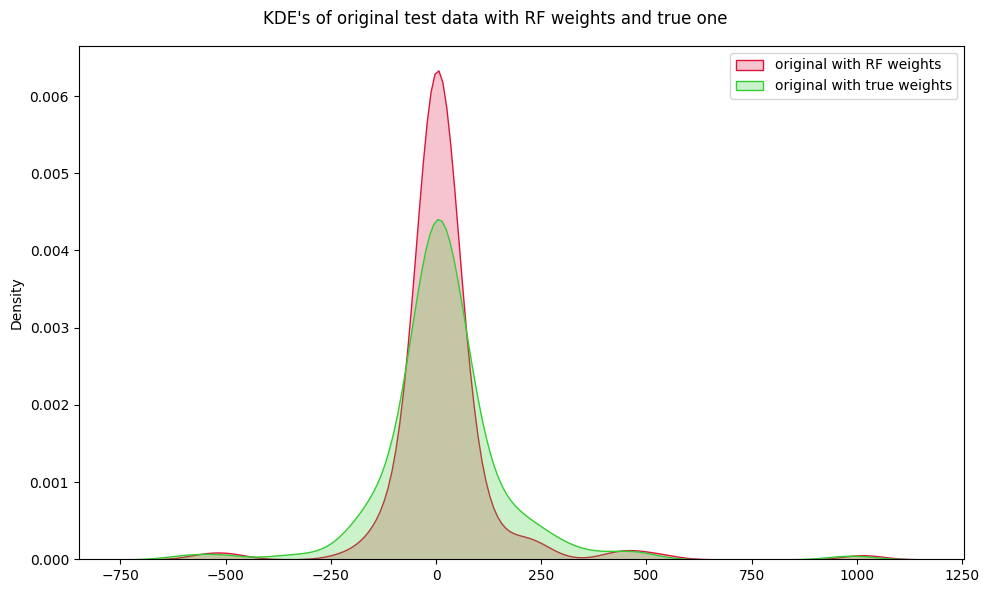

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("KDE's of original test data with RF weights and true one")
sns.kdeplot(data=weights * X_test.values,
            color='crimson', label='original with RF weights', fill=True, ax=ax)
sns.kdeplot(data=true_weights_norm * X_test.values,
            color='limegreen', label='original with true weights', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

Now, try to estimate the qualities of the linear regression model on data with a different distribution with weights.


In [18]:
print(f"R2 score on TDS data with weights: {r2_score(tsd_test_data['Y'], regressor.predict(np.array(tsd_test_data['X']).reshape(-1,1)), sample_weight=weights)}")
print(f"MSE score on TDS data with weights: {mean_squared_error(tsd_test_data['Y'], regressor.predict(np.array(tsd_test_data['X']).reshape(-1,1)), sample_weight=weights)}")

R2 score on TDS data with weights: 0.864607336826751
MSE score on TDS data with weights: 247756.12745044567


### Confidence interval checking

In [19]:
def bootstrap_resampling(data, statistic_function, with_weights=None, num_samples=1000, alpha=0.05, seed=42):
    np.random.seed(seed) 
    sample_statistics = []

    for _ in range(num_samples):
        # Generate a bootstrap sample with replacement
        if with_weights:
            normalized_weights = np.array(with_weights) / sum(with_weights)
            bootstrap_sample = np.random.choice(data, size=len(data), replace=True, p=normalized_weights)
        else:
            bootstrap_sample = np.random.choice(data, size=len(data), replace=True)

        # Calculate the statistic on the bootstrap sample
        sample_statistic = statistic_function.predict(np.array(bootstrap_sample).reshape(-1,1))
        sample_statistics.append(sample_statistic)

    # Calculate the confidence interval based on alpha
    mean = np.mean(sample_statistics)
    lower_bound = np.percentile(sample_statistics, 100 * (alpha / 2))
    upper_bound = np.percentile(sample_statistics, 100 * (1 - alpha / 2))

    confidence_interval = (lower_bound, upper_bound)
    return mean, confidence_interval  

Let's look at mean and conf. interval on tsd w/o weights:

In [20]:
bootstrap_resampling(X_test.values, regressor) ## tsd w/o weights

(95.73495492191856, (-1221.380091383508, 1773.4659153878238))

And at mean and conf. interval on tsd with weights, but here firstly we need to train new regressor with weights:

In [22]:
regressor_weighted = LinearRegression().fit(np.array(X_train.values).reshape(-1, 1), 
                                            y_train, 
                                            sample_weight=[rf.predict_proba(item.reshape(1, -1))[0][0] for item in X_train.values])

In [23]:
bootstrap_resampling(X_test, regressor_weighted, weights)

(196.99037947446428, (-2288.503189433269, 2186.206276053487))

### Controlable distribution shift

In this section, let's try to implement a controlled target data shift. We need the same original data, but now we will get a shifted sample depending on the specified parameter.

In [2]:
data = pd.read_csv('./swedish_insurance_augmented.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
                                        data["X"], 
                                        data["Y"], 
                                        test_size=0.31, 
                                        random_state=None, 
                                        shuffle=True
                                    )

print(f"Length of train part: {len(X_train)}\nLength of original test part: {len(X_test)}")

Length of train part: 347
Length of original test part: 156


To shift the data, we сan define the function ```dist_shift_kde()```, in which the shift logic is based on the estimation of kde at the current sample and shift with a controlled parameter.

In [4]:
def dist_shift_kde(X_test_0, shift):
    kde = gaussian_kde(X_test_0)
    X_test_target = X_test_0 + shift * kde.resample(len(X_test_0)).reshape(-1)
    return X_test_target

I removed all the function that computes the regressors metrics, weights and confidence intervals in the function ```compute_metrics()```. Now by varying the shift parameter in the data can immediately get the necessary metrics and draw them.

Let's try specifying a list of shift values and look at the metrics:

In [5]:
shifts_values = [1, 2, 5, 10, 30, 50]

In [8]:
mse = []
ci = []
kde = []

for item in shifts_values:
    target_data = pd.DataFrame([], columns=['X', 'Y'])
    target_data["X"] = dist_shift_kde(X_test, item)
    target_data["Y"] =  dist_shift_kde(y_test, item)
    
    metrics_list = compute_metrics(X_train, y_train, X_test, y_test, target_data)
    
    mse.append(metrics_list[0])
    ci.append(metrics_list[1])
    kde.append(metrics_list[2])

#### MSE values at varying bias

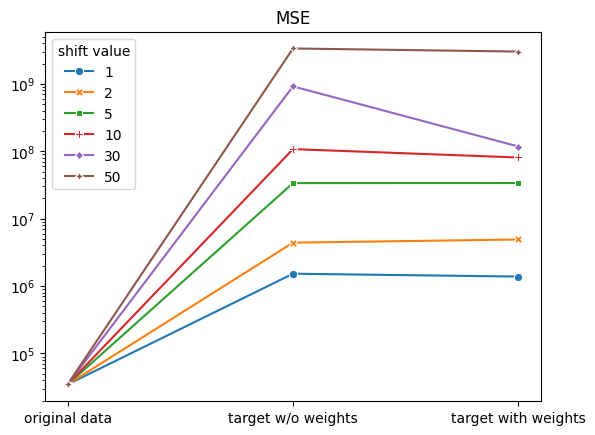

In [7]:
df = pd.DataFrame(mse, columns=['original data', 'target w/o weights', 'target with weights'])
df.index = shifts_values

sns.lineplot(data=df.T, dashes=False, markers=True)
plt.legend(title='shift value')
plt.yscale('log')
plt.title("MSE");

From the plots, it can be seen that weighting either keeps the MSE value about the same or makes it smaller compared to the unweighted value.

#### Confidence intervals with and without weights when varying the shift

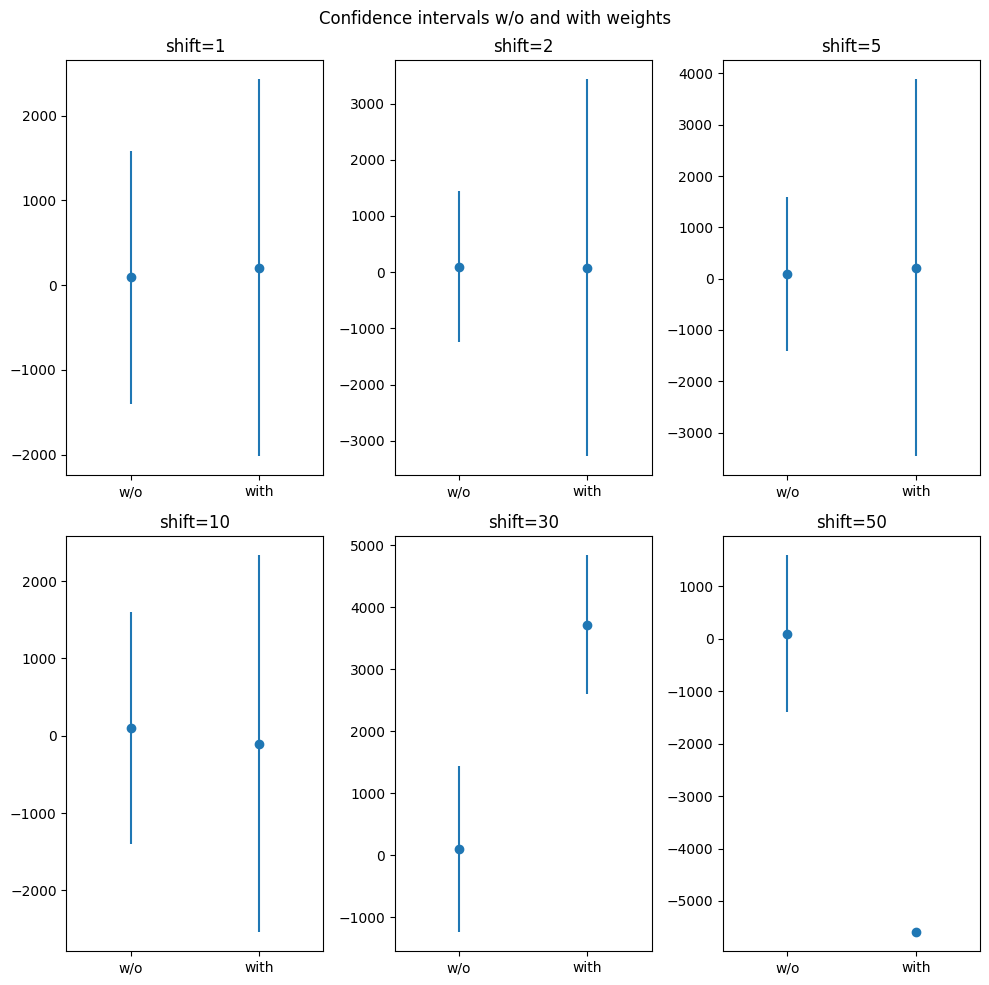

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10)) 
fig.suptitle('Confidence intervals w/o and with weights')

k = 0
for i in range(2):
    for j in range(3):
        axs[i, j].errorbar(x=[0,2], 
                 y=[item[0] for item in ci[k]], 
                 yerr=[(item[1][1] - item[1][0])/2 for item in ci[k]],
                 fmt='o')

        axs[i, j].set_xlim(-1, 3)
        axs[i, j].set_title(f'shift={shifts_values[k]}')
        axs[i, j].set_xticks((0, 2))
        axs[i, j].set_xticklabels(('w/o', 'with'))
        k += 1

plt.tight_layout();

#### KDE's of test data with true normalised weights and with RF weights when varying the shift

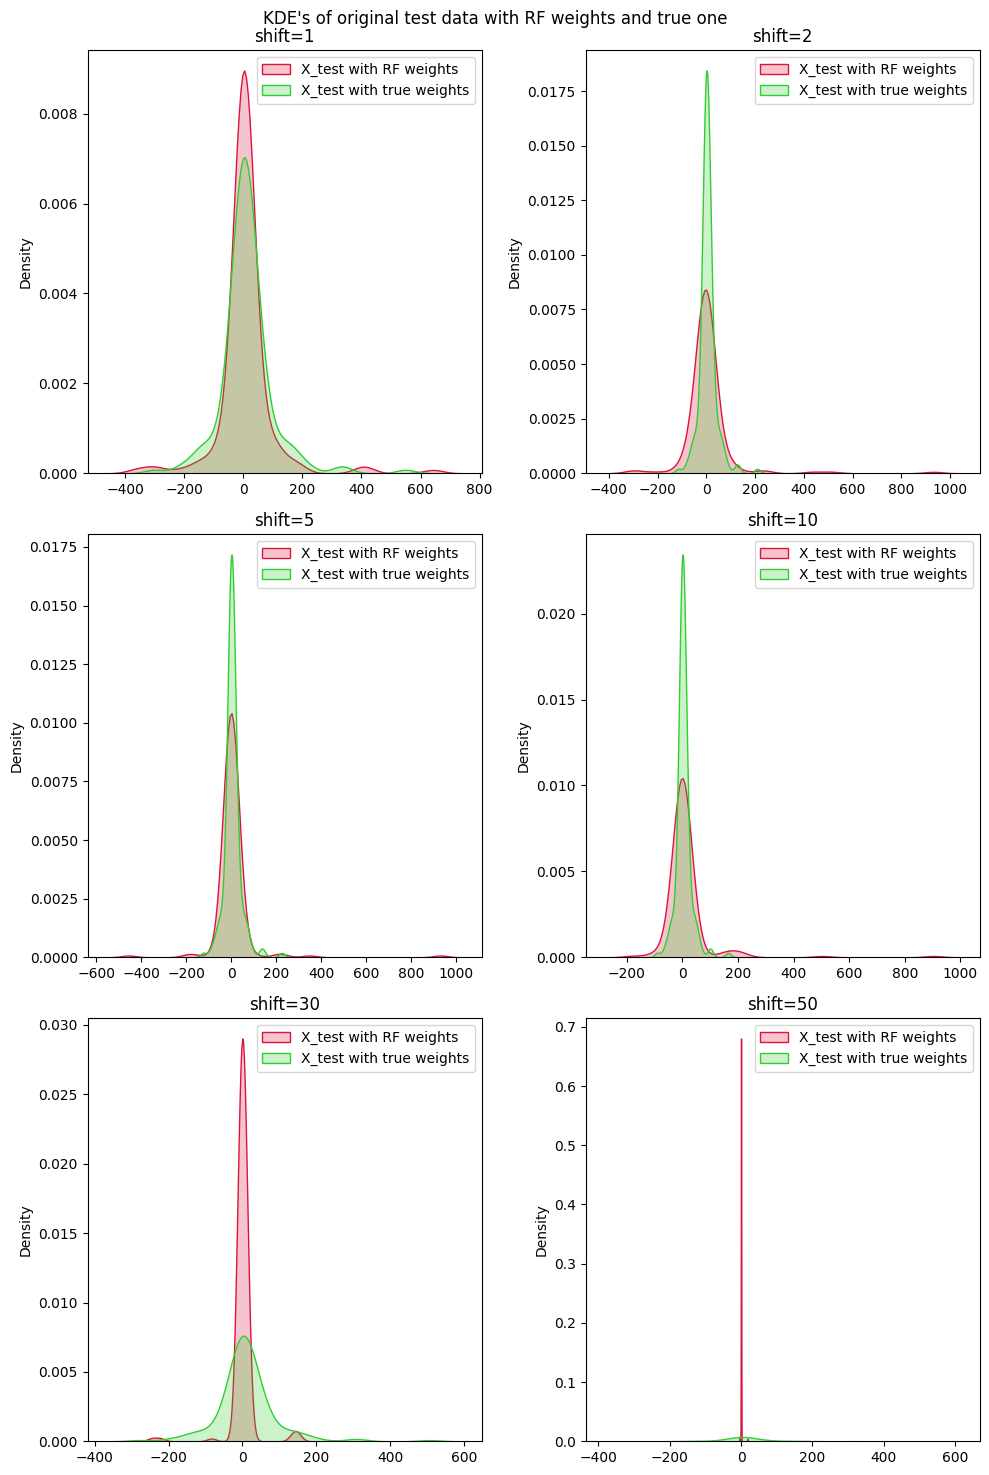

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))  
fig.suptitle("KDE's of original test data with RF weights and true one")

k = 0
for i in range(3):
    for j in range(2):
        sns.kdeplot(data=kde[k][0] * X_test.values,
            color='crimson', label='X_test with RF weights', fill=True, ax=axs[i, j])
        sns.kdeplot(data=kde[k][1] * X_test.values,
            color='limegreen', label='X_test with true weights', fill=True, ax=axs[i, j])
        
        axs[i, j].set_title(f'shift={shifts_values[k]}')
        axs[i, j].legend()
        k += 1

plt.tight_layout();

From these plots, it is reasonable to conclude that, for a small value of the bias, the current implementation allows the RF weights to approximate the true normalised weights quite well. However. we increase the value of the weight bias, the predicted RFs lag far behind the true ones, in this situation a better selection of parameters for RF training and control of the sample size is possible.

### Conformal predictions (in progress)

In [2]:
from sklearn.datasets import make_regression
from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor

In [3]:
data = pd.read_csv('./swedish_insurance_augmented.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                        data["X"], 
                                        data["Y"], 
                                        test_size=0.31, 
                                        random_state=None, 
                                        shuffle=True
                                    )

print(f"Length of train part: {len(X_train)}\nLength of original test part: {len(X_test)}")

Length of train part: 347
Length of original test part: 156


In [5]:
def dist_shift_kde(X_test_0, shift):
    kde = gaussian_kde(X_test_0)
    X_test_target = X_test_0 + shift * kde.resample(len(X_test_0)).reshape(-1)
    return X_test_target

In [6]:
target_data = pd.DataFrame([], columns=['X', 'Y'])
target_data["X"] = dist_shift_kde(X_test, 2)
target_data["Y"] =  dist_shift_kde(y_test, 2)

In [7]:
regressor = LinearRegression().fit(np.array(X_train.values).reshape(-1, 1), y_train)

/usr/local/lib/python3.8/dist-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


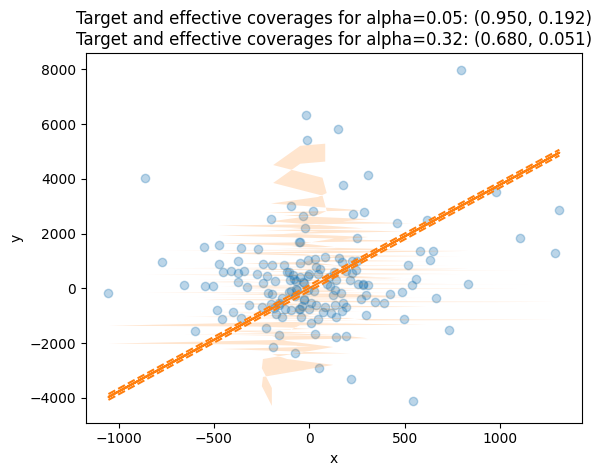

In [8]:
alpha = [0.05, 0.32]
mapie = MapieRegressor(regressor, cv="prefit")
mapie.fit(np.array(X_train).reshape(-1,1), y_train)
y_pred, y_pis = mapie.predict(np.array(target_data['X']).reshape(-1,1), alpha=alpha)

coverage_scores = [
    regression_coverage_score(target_data['Y'], y_pis[:, 0, i], y_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]

plt.xlabel("x")
plt.ylabel("y")
plt.scatter(np.array(target_data['X']).reshape(-1,1), target_data['Y'], alpha=0.3)
plt.plot(np.array(target_data['X']).reshape(-1,1), y_pred, color="C1")
order = np.argsort(target_data['X'].tolist())
plt.plot(target_data['X'].iloc[order].tolist(), y_pis[order][:, 0, 1], color="C1", ls="--")
plt.plot(target_data['X'].iloc[order].tolist(), y_pis[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    target_data['X'].tolist(),
    y_pis[order][:, 0, 0].ravel(),
    y_pis[order][:, 1, 0].ravel(),
    alpha=0.2,
)
plt.title(
    f"Target and effective coverages for "
    f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
    f"Target and effective coverages for "
    f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
)
plt.show();
